In [1]:
!pip install efficientnet -q
!pip install ensemble-boxes

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import ast
import json
import os
import re
import shutil
import sys
import warnings
from itertools import chain

import cv2
import efficientnet.tfkeras as efn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom as dicom
import tensorflow as tf
import tensorflow_addons as tfa
import torch
from ensemble_boxes import *
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import clear_output
from numba import cuda
from PIL import Image
from tensorflow import keras
from tqdm import tqdm
from time import time
from test_utils.test_utils import Generator, Test

# warnings.filterwarnings("ignore")
InteractiveShell.ast_node_interactivity = "all"

In [3]:
sample_submission = pd.read_csv("/app/_data/sample_submission.csv")
sub_study = sample_submission[
    sample_submission["id"].str.contains("_study")
].reset_index(drop=True)
sub_image = sample_submission[
    sample_submission["id"].str.contains("_image")
].reset_index(drop=True)
labels = ["negative", "typical", "indeterminate", "atypical"]
if sample_submission.shape[0] == 2477:
    TRAIN_MODE = True
else:
    TRAIN_MODE = False
OBJ_DET = True
CLASSIFICATION = True
NORM = False
CROP = True

TRAIN_MODE

True

In [4]:
TRAIN_MODE = False

In [5]:
TEST_PATH = "/app/_data/test/"
# TEST_PATH = "/app/_data/train/"
TEST_JPG_PATH = "/app/_data/tmp/"
CROP_MODEL_PATH = "/app/_data/models/CropBest/EffB0_3.h5" if CROP else None
CACHE_CLASS_PATH = "/app/_data/class_img_path/"
MODEL_PATH = ["/app/_data/models/EffB7_cropped/", "/app/_data/models/EffB7_cropped/"]
MODEL_2CL_PATH = None
RESIZED_YOLO_PATH = '/app/_data/tmp_1024/'

In [6]:
shutil.rmtree("/app/_data/tmp/")
test_df = Test.prepare_data(
    data_path=TEST_PATH,
    path_to_save=TEST_JPG_PATH,
    train_mode=TRAIN_MODE,
    n_train_sample=100,
    norm=False,
    jpg=True,
    crop_model_path=CROP_MODEL_PATH,
    class_img_path=CACHE_CLASS_PATH,
    resized_yolo_path = RESIZED_YOLO_PATH,
    yolo_img_size=1024
)
test_df.head()

100%|██████████| 1214/1214 [14:30<00:00,  1.40it/s]
/app/src/test_utils/test_utils.py:129: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df["path"] = test_df["path"].str.replace("\../", "/kaggle/")


path StudyInstanceUID  \
0  /app/_data/test/fe64182ae21d/d56579abcb25/a82c...     fe64182ae21d   
1  /app/_data/test/6117058c3931/d51d2a5e7f7a/b74f...     6117058c3931   
2  /app/_data/test/b83eaac8a377/326c25201eea/1c13...     b83eaac8a377   
3  /app/_data/test/9fab41ffbc39/5b8d372f6714/fa0c...     9fab41ffbc39   
4  /app/_data/test/4e4ee0341fab/70ae5f9ad500/dc68...     4e4ee0341fab   

          image modality PatientSex BodyPartExamined  \
0  a82ca8f37fb6       CR          F            CHEST   
1  b74f81d65e79       DX          M            CHEST   
2  1c13336fc8a9       DX          M            CHEST   
3  fa0c84ee4577       CR          F            CHEST   
4  dc6834a1efa6       CR          F            CHEST   

  PhotometricInterpretation   width  height        xmin        ymin  \
0               MONOCHROME2  4248.0  3480.0  696.615745  415.937771   
1               MONOCHROME2  3032.0  3032.0  254.029222  449.704807   
2               MONOCHROME2  3032.0  2520.0  139.052027  159.620613   
3               MONOCHROME1  4240.0  3480.0  684.959997  332.563006   
4               MONOCHROME2  2621.0  2597.0  391.542356  142.102837   

          xmax         ymax  
0  3249.935160  2350.577502  
1  2591.709461  2582.702674  
2  2422.882711  2007.415738  
3  3083.760796  2705.033040  
4  2379.100609  1899.406361

# Classification

In [10]:
start = time()
tf.keras.backend.clear_session()
if CLASSIFICATION:
    gen = Generator(
        df=test_df, img_size=600, batch_size=1, norm=NORM, crop=CROP, cache_path=None
    )
    pred_df = Test.make_predictions(
        test_df_=test_df, model_path=MODEL_PATH, generator=gen, neg_cl=False
    )
    pred_df = pred_df.merge(test_df[["image", "StudyInstanceUID"]], on="image")
    pred_df.head()
end = time()
end - start

image  negative   typical  indeterminate  atypical model  \
0  a82ca8f37fb6  0.020344  0.796211       0.131917  0.051527     0   
1  a82ca8f37fb6  0.043629  0.726764       0.125760  0.103848     1   
2  a82ca8f37fb6  0.020344  0.796211       0.131917  0.051527     2   
3  a82ca8f37fb6  0.043629  0.726764       0.125760  0.103848     3   
4  b74f81d65e79  0.165923  0.588551       0.183976  0.061551     0   

  StudyInstanceUID  
0     fe64182ae21d  
1     fe64182ae21d  
2     fe64182ae21d  
3     fe64182ae21d  
4     6117058c3931

895.1578469276428

In [8]:
def make_study_submission(pred_df_, test_df_, sub_study_, labels_, max_id=True):
    sub_study_["StudyInstanceUID"] = sub_study_["id"].str[:-6]
    if TRAIN_MODE:
        list_study_ids = pred_df_["StudyInstanceUID"].unique().tolist()
        sub_study_ = sub_study_.query("StudyInstanceUID in @list_study_ids")
    for ix in sub_study_.index.tolist():
        study_name = sub_study_.loc[ix, "StudyInstanceUID"]
        new_df = pred_df_[pred_df_["StudyInstanceUID"] == study_name]
        list_max_pred = []
        list_pred = []
        for col in labels_:
            list_max_pred.append(
                sorted(new_df[col].values, reverse=True)[
                    : (len(new_df[col].values) // 2) + 1
                ]
            )
            list_pred.append(sorted(new_df[col].values, reverse=True))
        ix_max = np.argmax([np.mean(x) for x in list_max_pred])
        if max_id:
            predictions = []
            for i in range(4):
                if i == ix_max:
                    predictions.append(
                        labels_[i] + " " + str(np.mean(list_max_pred[i])) + " 0 0 1 1"
                    )
                else:
                    predictions.append(
                        labels_[i] + " " + str(np.mean(list_pred[i])) + " 0 0 1 1"
                    )
        else:
            predictions = [
                labels_[i] + " " + str(np.mean(list_pred[i])) + " 0 0 1 1"
                for i in range(4)
            ]
        sub_study_.loc[ix, "PredictionString"] = " ".join(predictions)
    for ix in test_df_.index.tolist():
        img_name = test_df_.loc[ix, "image"]
        new_df = pred_df_[pred_df_["image"] == img_name]
        for col in labels_:
            if max_id:
                test_df_.loc[ix, col] = np.mean(
                    sorted(new_df[col].values, reverse=True)[
                        : (len(new_df[col].values) // 2) + 1
                    ]
                )
            else:
                test_df_.loc[ix, col] = np.mean(new_df[col].values)
    return sub_study_, test_df_

In [56]:
sub_study, test_df = make_study_submission(
    pred_df_=pred_df,
    test_df_=test_df,
    sub_study_=sub_study,
    labels_=labels,
    max_id=True,
)
sub_study.head()
sub_study.shape
test_df.head()
test_df.shape

id                                   PredictionString  \
0  00188a671292_study  negative 0.4459696213404338 0 0 1 1 typical 0....   
1  004bd59708be_study  negative 0.028112630592659116 0 0 1 1 typical ...   
2  00508faccd39_study  negative 0.49601354201634723 0 0 1 1 typical 0...   
3  006486aa80b2_study  negative 0.12542743608355522 0 0 1 1 typical 0...   
4  00655178fdfc_study  negative 0.30940039455890656 0 0 1 1 typical 0...   

  StudyInstanceUID  
0     00188a671292  
1     004bd59708be  
2     00508faccd39  
3     006486aa80b2  
4     00655178fdfc

(1214, 3)

path StudyInstanceUID  \
0  /app/_data/test/fe64182ae21d/d56579abcb25/a82c...     fe64182ae21d   
1  /app/_data/test/6117058c3931/d51d2a5e7f7a/b74f...     6117058c3931   
2  /app/_data/test/b83eaac8a377/326c25201eea/1c13...     b83eaac8a377   
3  /app/_data/test/9fab41ffbc39/5b8d372f6714/fa0c...     9fab41ffbc39   
4  /app/_data/test/4e4ee0341fab/70ae5f9ad500/dc68...     4e4ee0341fab   

          image modality PatientSex BodyPartExamined  \
0  a82ca8f37fb6       CR          F            CHEST   
1  b74f81d65e79       DX          M            CHEST   
2  1c13336fc8a9       DX          M            CHEST   
3  fa0c84ee4577       CR          F            CHEST   
4  dc6834a1efa6       CR          F            CHEST   

  PhotometricInterpretation   width  height        xmin        ymin  \
0               MONOCHROME2  4248.0  3480.0  696.615745  415.937771   
1               MONOCHROME2  3032.0  3032.0  254.029222  449.704807   
2               MONOCHROME2  3032.0  2520.0  139.052027  159.620613   
3               MONOCHROME1  4240.0  3480.0  684.959997  332.563006   
4               MONOCHROME2  2621.0  2597.0  391.542356  142.102837   

          xmax         ymax  negative   typical  indeterminate  atypical  
0  3249.935160  2350.577502  0.035867  0.773062       0.129865  0.086408  
1  2591.709461  2582.702674  0.299748  0.494371       0.216386  0.083675  
2  2422.882711  2007.415738  0.015679  0.813080       0.116802  0.064445  
3  3083.760796  2705.033040  0.007269  0.871621       0.090408  0.046531  
4  2379.100609  1899.406361  0.233632  0.499933       0.237405  0.094767

(1263, 17)

# yolo

In [7]:
%cd /app/_data/ScaledYOLOv4/mish-cuda
!python setup.py build install
%cd /app/_data/ScaledYOLOv4
clear_output()

In [8]:
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

<weakproxy at 0x7f404af13cc0 to Device at 0x7f429472af70>

<weakproxy at 0x7f404af13cc0 to Device at 0x7f429472af70>

In [9]:
start = time()
!python detect.py --weights /app/_data/ScaledYOLOv4/runs/exp2_yolov4lp7_1/weights/best.pt \
                  --source /app/_data/tmp \
                  --img-size 1024 \
                  --conf-thres 0.01 \
                  --iou-thres 0.5 \
                  --save-txt \
                  --output /app/_data/tmp/labels0/ \
                  --augment 
end = time()


Namespace(agnostic_nms=False, augment=True, classes=None, conf_thres=0.01, device='', img_size=1024, iou_thres=0.5, output='/app/_data/tmp/labels0/', save_txt=True, source='/app/_data/tmp', update=False, view_img=False, weights=['/app/_data/ScaledYOLOv4/runs/exp2_yolov4lp7_1/weights/best.pt'])
Using CUDA device0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', total_memory=24265MB)

Fusing layers... Model Summary: 503 layers, 2.85956e+08 parameters, 2.7862e+08 gradients
image 1/1263 /app/_data/tmp/0026720152f5.jpg: 1024x1024 14 opacitys, Done. (0.229s)
image 2/1263 /app/_data/tmp/00fc8fc35dc1.jpg: 1024x896 11 opacitys, Done. (0.231s)
image 3/1263 /app/_data/tmp/01c3512eebc3.jpg: 1024x1024 6 opacitys, Done. (0.203s)
image 4/1263 /app/_data/tmp/01f948f8e544.jpg: 1024x1024 9 opacitys, Done. (0.199s)
image 5/1263 /app/_data/tmp/022146012034.jpg: 1024x1024 2 opacitys, Done. (0.208s)
image 6/1263 /app/_data/tmp/02eceb0fc405.jpg: 896x1024 5 opacitys, Done. (0.236s)
image 7/1263 /app/_dat

In [14]:
!python detect.py --weights /app/_data/yolov4p7weights/comp_1_42.pt \
                  --source /app/_data/tmp \
                  --img-size 1024 \
                  --conf-thres 0.01 \
                  --iou-thres 0.5 \
                  --save-txt \
                  --output /app/_data/tmp/labels1/ \
                  --augment

Namespace(agnostic_nms=False, augment=True, classes=None, conf_thres=0.01, device='', img_size=1024, iou_thres=0.5, output='/app/_data/tmp/labels1/', save_txt=True, source='/app/_data/tmp', update=False, view_img=False, weights=['/app/_data/yolov4p7weights/comp_1_42.pt'])
Using CUDA device0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', total_memory=24265MB)

Fusing layers... Model Summary: 503 layers, 2.85956e+08 parameters, 2.7862e+08 gradients
image 1/1263 /app/_data/tmp/0026720152f5.jpg: 1024x1024 18 opacitys, Done. (0.217s)
image 2/1263 /app/_data/tmp/00fc8fc35dc1.jpg: 1024x896 18 opacitys, Done. (0.229s)
image 3/1263 /app/_data/tmp/01c3512eebc3.jpg: 1024x1024 9 opacitys, Done. (0.197s)
image 4/1263 /app/_data/tmp/01f948f8e544.jpg: 1024x1024 17 opacitys, Done. (0.198s)
image 5/1263 /app/_data/tmp/022146012034.jpg: 1024x1024 5 opacitys, Done. (0.196s)
image 6/1263 /app/_data/tmp/02eceb0fc405.jpg: 896x1024 10 opacitys, Done. (0.232s)
image 7/1263 /app/_data/tmp/03a778f5a68b.j

In [12]:
!python detect.py --weights /app/_data/yolov4p7weights/comp_2_42.pt\
                  --source /app/_data/tmp \
                  --img-size 1024 \
                  --conf-thres 0.01 \
                  --iou-thres 0.5 \
                  --save-txt \
                  --output /app/_data/tmp/labels2/ \
                  --augment

Namespace(agnostic_nms=False, augment=True, classes=None, conf_thres=0.01, device='', img_size=1024, iou_thres=0.5, output='/app/_data/tmp/labels2/', save_txt=True, source='/app/_data/tmp', update=False, view_img=False, weights=['/app/_data/yolov4p7weights/comp_2_42.pt'])
Using CUDA device0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', total_memory=24265MB)

Fusing layers... Model Summary: 503 layers, 2.85956e+08 parameters, 2.7862e+08 gradients
image 1/106 /app/_data/tmp/029fd29fcfff.jpg: 1024x1024 Done. (0.244s)
image 2/106 /app/_data/tmp/02a1efc9a703.jpg: 896x1024 11 opacitys, Done. (0.231s)
image 3/106 /app/_data/tmp/086f1ab39050.jpg: 896x1024 20 opacitys, Done. (0.204s)
image 4/106 /app/_data/tmp/0a29a6326e2b.jpg: 1024x1024 5 opacitys, Done. (0.197s)
image 5/106 /app/_data/tmp/0b55cd36e5cc.jpg: 1024x1024 11 opacitys, Done. (0.197s)
image 6/106 /app/_data/tmp/0c65c1436864.jpg: 896x1024 12 opacitys, Done. (0.202s)
image 7/106 /app/_data/tmp/130471fdc458.jpg: 896x1024 10 opac

In [13]:
!python detect.py --weights /app/_data/ScaledYOLOv4/runs/exp2_yolov4lp7_1/weights/best.pt /app/_data/yolov4p7weights/comp_2_42.pt \
                    /app/_data/yolov4p7weights/comp_1_42.pt \
                  --source /app/_data/tmp \
                  --img-size 1024 \
                  --conf-thres 0.01 \
                  --iou-thres 0.5 \
                  --save-txt \
                  --output /app/_data/tmp/labels4/ \
                  --augment

Namespace(agnostic_nms=False, augment=True, classes=None, conf_thres=0.01, device='', img_size=1024, iou_thres=0.5, output='/app/_data/tmp/labels4/', save_txt=True, source='/app/_data/tmp', update=False, view_img=False, weights=['/app/_data/ScaledYOLOv4/runs/exp2_yolov4lp7_1/weights/best.pt', '/app/_data/yolov4p7weights/comp_2_42.pt', '/app/_data/yolov4p7weights/comp_1_42.pt'])
Using CUDA device0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', total_memory=24265MB)

Fusing layers... Model Summary: 503 layers, 2.85956e+08 parameters, 2.7862e+08 gradients
Fusing layers... Model Summary: 503 layers, 2.85956e+08 parameters, 2.7862e+08 gradients
Fusing layers... Model Summary: 503 layers, 2.85956e+08 parameters, 2.7862e+08 gradients
Ensemble created with ['/app/_data/ScaledYOLOv4/runs/exp2_yolov4lp7_1/weights/best.pt', '/app/_data/yolov4p7weights/comp_2_42.pt', '/app/_data/yolov4p7weights/comp_1_42.pt']

image 1/106 /app/_data/tmp/029fd29fcfff.jpg: 1024x1024 Done. (0.610s)
image 2/106

In [34]:
TXT_PATH = [
    "/app/_data/tmp/labels0/",
    "/app/_data/tmp/labels1/",
    #     "/app/_data/tmp/labels2/",
]

In [48]:
def bbox_preidction(
    df,
    sub_image_,
    bbox_folders,
    IOU_THR=0.63,
    SKIP_BOX_THR=0.01,
    SIGMA=0.1,
    WBF=True,
    NMS=False,
    WEIGHTS=None,
    SOFT_NMS=False,
    NMW=False,
):

    for ix in sub_image_.index.tolist():
        img_name = sub_image_.loc[ix, "id"][:-6]

        w = df[df["image"] == img_name]["width"].values[0]
        h = df[df["image"] == img_name]["height"].values[0]
        bb_list = []
        conf_list = []
        class_list = []
        file = img_name + ".txt"
        for folder in bbox_folders:
            if file in os.listdir(folder):
                ls = np.loadtxt(folder + file)
                if ls.ndim == 1:
                    ls = ls.reshape(1, -1)
                boxes_list = ls[:, 1:5].copy()
                bl = ls[:, 1:5].copy()
                boxes_list[:, 0] = bl[:, 0] - bl[:, 2] / 2
                boxes_list[:, 1] = bl[:, 1] - bl[:, 3] / 2
                boxes_list[:, 2] = bl[:, 0] + bl[:, 2] / 2
                boxes_list[:, 3] = bl[:, 1] + bl[:, 3] / 2
                bb_list.append(boxes_list)
                conf_list.append(ls[:, 5])
                class_list.append(ls[:, 0])
        if WBF:
            boxes, scores, labels = weighted_boxes_fusion(
                bb_list,
                conf_list,
                class_list,
                weights=WEIGHTS,
                iou_thr=IOU_THR,
                skip_box_thr=SKIP_BOX_THR,
            )
        elif NMS:
            boxes, scores, labels = nms(
                bb_list, conf_list, class_list, weights=WEIGHTS, iou_thr=IOU_THR
            )
        elif SOFT_NMS:
            boxes, scores, labels = soft_nms(
                bb_list,
                conf_list,
                class_list,
                weights=WEIGHTS,
                iou_thr=IOU_THR,
                sigma=SIGMA,
                thresh=SKIP_BOX_THR,
            )
        elif NMW:
            boxes, scores, labels = non_maximum_weighted(
                bb_list,
                conf_list,
                class_list,
                weights=WEIGHTS,
                iou_thr=IOU_THR,
                skip_box_thr=SKIP_BOX_THR,
            )
        xmin = boxes[:, 0] * w
        ymin = boxes[:, 1] * h
        xmax = boxes[:, 2] * w
        ymax = boxes[:, 3] * h
        list_pred = [
            f"opacity {scores[i]} {xmin[i]} {ymin[i]} {xmax[i]} {ymax[i]}"
            for i in range(len(boxes))
        ]
        sub_image_.loc[ix, "PredictionString"] = " ".join(list_pred)
    return sub_image_

In [49]:
sub_image = bbox_preidction(
    df=test_df,
    sub_image_=sub_image,
    bbox_folders=TXT_PATH,
    IOU_THR=0.63,
    SKIP_BOX_THR=0.01,
    SIGMA=0.1,
    WBF=True,
    NMS=False,
    WEIGHTS=None,
    SOFT_NMS=False,
    NMW=False,
)
sub_image.head()

/usr/local/lib/python3.8/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:64: UserWarning: X1 < 0 in box. Set it to 0.
  warnings.warn('X1 < 0 in box. Set it to 0.')
/usr/local/lib/python3.8/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/usr/local/lib/python3.8/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:76: UserWarning: Y1 < 0 in box. Set it to 0.
  warnings.warn('Y1 < 0 in box. Set it to 0.')
/usr/local/lib/python3.8/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


id                                   PredictionString
0  557a70442928_image  opacity 0.098136 2212.998432 1716.99942 2982.0...
1  36141cda67ad_image  opacity 0.2693130075931549 3223.9372777938843 ...
2  2413a23a5477_image  opacity 0.6280875205993652 1643.7047567367554 ...
3  c263b1e9aa64_image  opacity 0.5845134854316711 1787.1858512163162 ...
4  4fe0444d7fc5_image  opacity 0.44188201427459717 755.4324778318405 ...

In [52]:
for ix in sub_image.index.tolist():
    if sub_image.loc[ix, "PredictionString"] == "":
        img_name = sub_image.loc[ix, "id"][:-6]
        neg_conf = test_df[test_df["image"] == img_name]["negative"].values[0]
        sub_image.loc[ix, "PredictionString"] = f"none {neg_conf} 0 0 1 1"

In [53]:
sub_image[~sub_image["PredictionString"].str.contains("opa")]

id                 PredictionString
34    abedbc04a891_image  none 0.6451437175273895 0 0 1 1
115   0418a303883e_image  none 0.7075928648312887 0 0 1 1
1177  fe0cf147b965_image  none 0.7798894246419271 0 0 1 1

In [54]:
# if os.path.exists("/kaggle/working/yolov5_test"):
#     shutil.rmtree("/kaggle/working/yolov5_test")
# if os.path.exists("/kaggle/working/test_imgs"):
#     shutil.rmtree("/kaggle/working/test_imgs")

In [55]:
submission = pd.concat([sub_study, sub_image], ignore_index=True, axis=0)
submission

id                                   PredictionString
0     00188a671292_study                                 negative 1 0 0 1 1
1     004bd59708be_study                                 negative 1 0 0 1 1
2     00508faccd39_study                                 negative 1 0 0 1 1
3     006486aa80b2_study                                 negative 1 0 0 1 1
4     00655178fdfc_study                                 negative 1 0 0 1 1
...                  ...                                                ...
2472  46719b856de1_image  opacity 0.07735635340213776 507.4874556809664 ...
2473  31c07523a69a_image  opacity 0.6694890260696411 2759.6746578216553 ...
2474  f77d7d1aebab_image  opacity 0.0739235 715.999086 1563.998925999999...
2475  ccc5b63ca96d_image  opacity 0.7110379934310913 539.5062972307205 7...
2476  5e8ac1fe2b82_image  opacity 0.7124639749526978 537.7490990161896 7...

[2477 rows x 2 columns]

In [12]:
# submission.to_csv("/kaggle/working/submission.csv", index=False)

In [13]:
# plt.figure(figsize=(20, 20))
# sample_df = sub_image[sub_image['PredictionString']!='none 1 0 0 1 1'].sample(20).reset_index(drop=True)
# for i in range(20):
#     img = Image.open('/kaggle/working/yolov5_test/'+sample_df.loc[i,'id'][:-6]+'.jpg')
#     ax = plt.subplot(5, 4, i + 1)
#     raw_boxes = sample_df.loc[i,"PredictionString"].split()
#     boxes = []
#     for i in range(0,len(raw_boxes),6):
#         boxes.append([int(raw_boxes[i+2]), int(raw_boxes[i+3]),int(raw_boxes[i+4]),int(raw_boxes[i+5])])
#     for box in boxes:
#         rect = plt.Rectangle(
#             (box[0], box[1]),
#             (box[2] -box[0] ),
#            ( box[3] - box[1]),
#            ec="b", fc="none", lw=4.0,
#            alpha=0.3
#         )
#         ax.add_patch(rect)
#     ax.imshow(img, cmap=plt.cm.bone)
#     plt.xticks([])
#     plt.yticks([])
# plt.show();

# predicting cropped images

In [7]:
test_df = pd.read_csv("/app/_data/test.csv")

In [8]:
test_df

path StudyInstanceUID  \
0     /app/_data/test/fe64182ae21d/d56579abcb25/a82c...     fe64182ae21d   
1     /app/_data/test/6117058c3931/d51d2a5e7f7a/b74f...     6117058c3931   
2     /app/_data/test/b83eaac8a377/326c25201eea/1c13...     b83eaac8a377   
3     /app/_data/test/9fab41ffbc39/5b8d372f6714/fa0c...     9fab41ffbc39   
4     /app/_data/test/4e4ee0341fab/70ae5f9ad500/dc68...     4e4ee0341fab   
...                                                 ...              ...   
1258  /app/_data/test/2b9ad8c6a010/f251e7f2407f/ebf5...     2b9ad8c6a010   
1259  /app/_data/test/f85b5d51e41d/2d7b14036f33/f785...     f85b5d51e41d   
1260  /app/_data/test/f66894c11824/096698ca90ea/88de...     f66894c11824   
1261  /app/_data/test/92d320a0719d/e76f6b98e5f5/b854...     92d320a0719d   
1262  /app/_data/test/514c5133572d/db1f16a85e54/eb9a...     514c5133572d   

          id_image modality PatientSex BodyPartExamined  \
0     a82ca8f37fb6       CR          F            CHEST   
1     b74f81d65e79       DX          M            CHEST   
2     1c13336fc8a9       DX          M            CHEST   
3     fa0c84ee4577       CR          F            CHEST   
4     dc6834a1efa6       CR          F            CHEST   
...            ...      ...        ...              ...   
1258  ebf5edbbed2d       DX          M            CHEST   
1259  f785f9c6bbf7       DX          M            CHEST   
1260  88debce8e1c3       DX          F            CHEST   
1261  b854ff324fbb       DX          M            CHEST   
1262  eb9a9b9a0870       DX          M            CHEST   

     PhotometricInterpretation   width  height         image  
0                  MONOCHROME2  4248.0  3480.0  a82ca8f37fb6  
1                  MONOCHROME2  3032.0  3032.0  b74f81d65e79  
2                  MONOCHROME2  3032.0  2520.0  1c13336fc8a9  
3                  MONOCHROME1  4240.0  3480.0  fa0c84ee4577  
4                  MONOCHROME2  2621.0  2597.0  dc6834a1efa6  
...                        ...     ...     ...           ...  
1258               MONOCHROME1  3408.0  2800.0  ebf5edbbed2d  
1259               MONOCHROME2  3285.0  2800.0  f785f9c6bbf7  
1260               MONOCHROME2  3056.0  2544.0  88debce8e1c3  
1261               MONOCHROME2  2170.0  2203.0  b854ff324fbb  
1262               MONOCHROME2  2673.0  2330.0  eb9a9b9a0870  

[1263 rows x 10 columns]

In [13]:
test_df["image"] = test_df["id_image"]

In [10]:
model = keras.models.load_model("/app/_data/models/crop/EffB0_3.h5")  # best

In [11]:
test_df.columns

Index(['path', 'StudyInstanceUID', 'id_image', 'modality', 'PatientSex',
       'BodyPartExamined', 'PhotometricInterpretation', 'width', 'height',
       'image'],
      dtype='object')

In [14]:
gen = Gen(
    df=test_df,
    label_columns=["width", "width", "width", "width"],
    batch_size=1,
    img_size=224,
    seed=42,
    cache_img_path="/app/_data/npy_224/",
    shuffle=False,
    augment_fn=None,
    crop=False,
)

In [15]:
for ix in tqdm(test_df.index.tolist()):
    img, coord = gen.__getitem__(ix)
    pred = model.predict(img)[0]
    test_df.loc[ix, "xmin"] = pred[0]
    test_df.loc[ix, "ymin"] = pred[1]
    test_df.loc[ix, "xmax"] = pred[2]
    test_df.loc[ix, "ymax"] = pred[3]

100%|██████████| 1263/1263 [04:46<00:00,  4.41it/s]


In [16]:
test_df["crop_w"] = (test_df["xmax"] - test_df["xmin"]) * test_df["width"]
test_df["crop_h"] = (test_df["ymax"] - test_df["ymin"]) * test_df["height"]

In [17]:
test_df["crop_w"].min()
test_df["crop_h"].describe()

771.8576078116894

count    1263.000000
mean     1902.269814
std       477.651007
min       539.626062
25%      1628.981194
50%      1872.183294
75%      2172.174574
max      3511.750662
Name: crop_h, dtype: float64

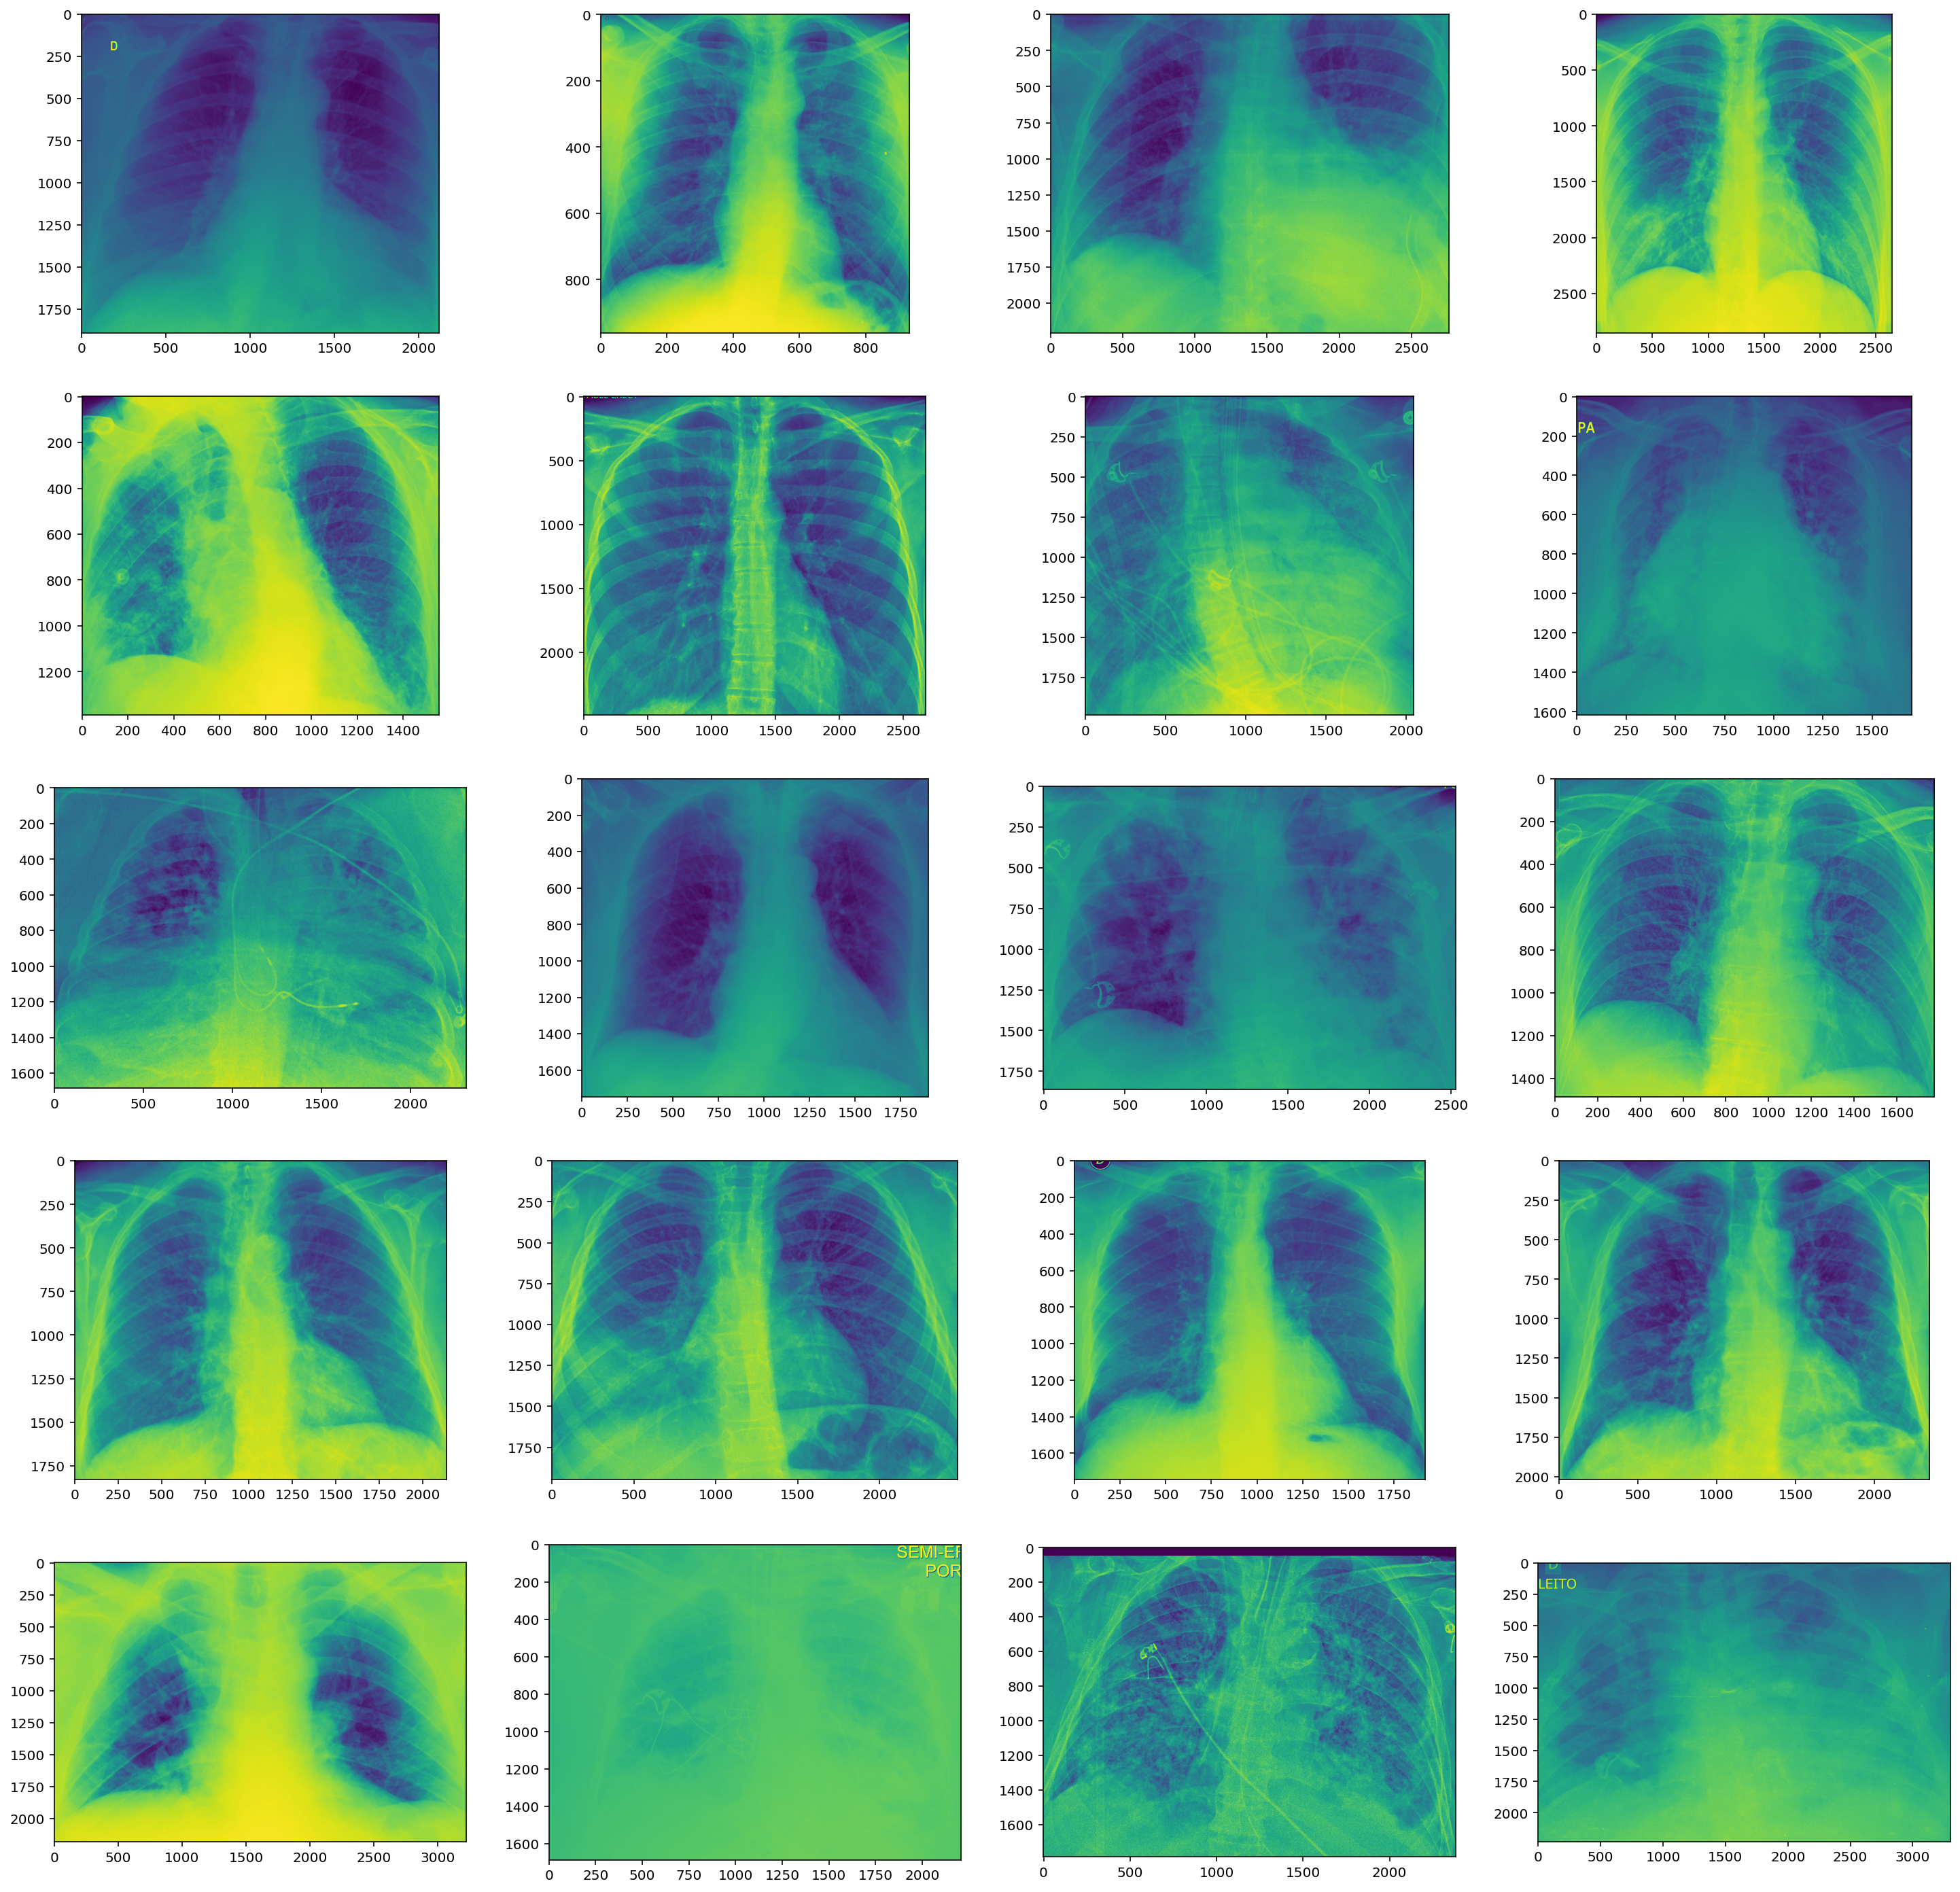

In [25]:
plt.figure(figsize=(25, 25))

for i in range(20):
    ix = np.random.randint(0, len(test_df))
    data_file = dicom.dcmread(test_df.loc[ix, "path"])
    coord = test_df.loc[ix, ["xmin", "ymin", "xmax", "ymax"]].values
    img = data_file.pixel_array
    if test_df.loc[ix, "PhotometricInterpretation"] == "MONOCHROME1":
        img = img.max() - img
    img = (img - img.min()) / (img.max() - img.min())
    img = (np.array(img) * 255).astype("uint8")
    xmin = coord[0] * img.shape[1]
    ymin = coord[1] * img.shape[0]
    xmax = coord[2] * img.shape[1]
    ymax = coord[3] * img.shape[0]
    plt.subplot(5, 4, i + 1)
    img = img[int(ymin) : int(ymax), int(xmin) : int(xmax)]
    plt.imshow(img)
plt.show();

In [24]:
test_df.to_csv("/app/_data/test.csv", index=False)